In [27]:
#comment out if not using colab
#from google.colab import files
#uploaded = files.upload()

In [1]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,LSTM,TimeDistributed,Dense,Flatten,Dropout,RepeatVector,GRU,Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.optimizers import Adam

In [3]:
filename='pre_data_dl.xlsx'
data_dl=pd.read_excel(filename)
pd.set_option('display.max_columns', None)
print(data_dl.head())

filename1='pre_data_dl_aug1.xlsx'
filename2='pre_data_dl_aug2.xlsx'

data_dl_aug1=pd.read_excel(filename1)
pd.set_option('display.max_columns', None)
print(data_dl_aug1.head())

data_dl_aug2=pd.read_excel(filename2)
print(data_dl_aug2.head())


   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                        Combined Description Cleaned Assignment group  
0  login issue user manager name checked the name...            GRP_0  
1  outlook received from hello team my are not in...            GRP_0  
2    cannot log in to received from   cannot on best            GRP_0  
3                         unable to access tool page            GRP_0  
4                                              error            GRP_0  
   Unnamed: 0                       Combined Description Cleaned  \
0           0  login issue user manager name checked the name...   
1           1  outlook received from hello team my are not in...   
2           2  cannot log in to received from hi i cannot on ...   
3           3                         unable to access tool page   
4           4                            

In [4]:
X = (data_dl["Combined Description Cleaned"])
y= (data_dl['Assignment group'])

#categorical encoding y
y=pd.get_dummies(data_dl['Assignment group'])
  

In [5]:
#parameters
max_features=10000
emb_dim=300
batch_size=128
epochs=25

In [6]:
#function for tokenizer
def dfTokenizer(df):
 tokenizer=Tokenizer(num_words=max_features,char_level=False)
 tokenizer.fit_on_texts(df)
 sequences=tokenizer.texts_to_sequences(df)
 return sequences,tokenizer
#tokenization
X,tokenizer = dfTokenizer(data_dl["Combined Description Cleaned"]) 
vocab_size=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size)

vocabulary size is:  3316


In [7]:
#function for padding
def pad(x, length=None):
 if length is None:
   length=max([len(sentence)  for sentence in x])
 return pad_sequences(x,maxlen=length,padding='post')
 
 #padding 
X=pad_sequences(X,padding='post')

In [8]:
#function for splitting the data
def split(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.2,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl
#split the data
X_train,X_test,y_train,y_test=split(X,y)


In [9]:
#configuring the callback
early_stopping =  EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    min_delta=0.001, 
    mode='max'
)

In [10]:
#function for plotting accuracy,loss
def plot(model,history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epochs = range(1, len(acc) + 1)
 plt.plot(epochs, acc, 'bo', label='Training acc')
 plt.plot(epochs, val_acc, 'b', label='Validation acc')
 plt.title(modelname + ' Training and validation accuracy')
 plt.legend()
 plt.figure()
 plt.plot(epochs, loss, 'bo', label='Training loss')
 plt.plot(epochs, val_loss, 'b', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
 plt.show()
 return 
inp_len=X.shape[1]
print(inp_len)

189


In [11]:
#Simple LSTM model
def LSTM_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(LSTM(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model
 
#Using GRU
def GRU_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(GRU(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model    

#BILSTM
def BILSTM_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(LSTM(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model

#Using bidirectional GRU
def BIGRU_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(GRU(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model



In [19]:
#customising the kerastuner function to include batch size and epochs
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
     kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 256, 512,step=256 )
     #kwargs['epochs'] = trial.hyperparameters.Int('epochs', 5, 10,20)
     super(MyTuner, self).run_trial(trial, *args, **kwargs)

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/40a\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 189, 512)          1665024   
_________________________________________________________________
dropout (Dropout)            (None, 189, 512)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 189, 512)          262656    
_________________________________________________________________
flatten (Flatten)            (None, 96768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7160906   
Total params: 12

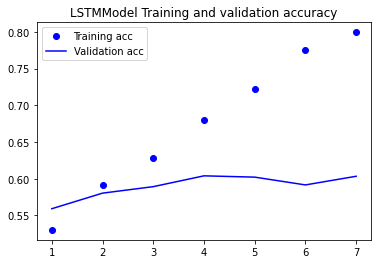

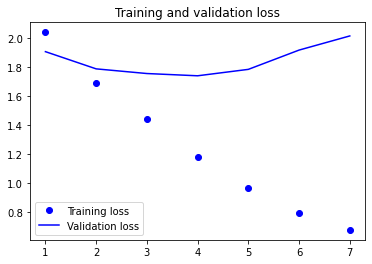

In [39]:
tuner =MyTuner(
    LSTM_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40a"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_LSTM,history)

In [40]:
scores_LSTM =best_model_LSTM.evaluate(X_test, y_test, verbose=0)
scores_LSTM_val = best_model_LSTM.evaluate(X_train, y_train, verbose=0)

In [41]:
print("Accuracy of LSTM for unaugmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of LSTM for unagumented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of LSTM for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of LSTM for unaugmented data is :",np.array(history.history['loss']).mean())

Accuracy of LSTM for unaugmented data is : 59.0032832963126
Training Accuracy of LSTM for unagumented data is: 67.52021653311593
Mean loss of  Validation data of LSTM for unaugmented data is : 1.8459778683526176
Mean loss of  Training data of LSTM for unaugmented data is : 1.256141415664128


Trial 5 Complete [00h 02m 19s]
val_accuracy: 0.5415439009666443

Best val_accuracy So Far: 0.5415439009666443
Total elapsed time: 00h 11m 04s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/40b\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
Score: 0.5415439009666443
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.483205646276474
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
Score: 0.483205646276474
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.483205646276474
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
Score: 0.41190335154533386
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3000

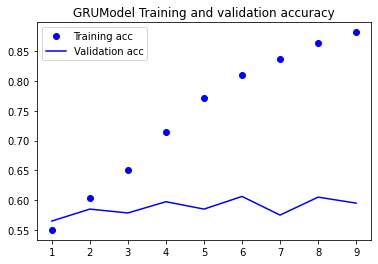

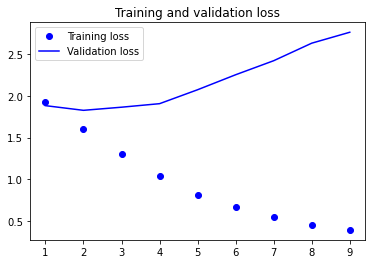

In [42]:
tuner =MyTuner(
    GRU_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40b"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)


modelname="GRUModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_GRU,history)

In [43]:
print("Accuracy of GRU for unaugmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of GRU for unagumented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of GRU for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of GRU for unaugmented data is :",np.array(history.history['loss']).mean())

Accuracy of GRU for unaugmented data is : 58.816211753421356
Training Accuracy of GRU for unagumented data is: 74.23185176319546
Mean loss of  Validation data of GRU for unaugmented data is : 2.178678962919447
Mean loss of  Training data of GRU for unaugmented data is : 0.9728716181384193


Trial 5 Complete [00h 06m 23s]
val_accuracy: 0.49558043479919434

Best val_accuracy So Far: 0.49558043479919434
Total elapsed time: 00h 29m 26s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/40C\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
Score: 0.49558043479919434
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.483205646276474
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
Score: 0.483205646276474
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.483205646276474
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
Score: 0.43606364727020264
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3

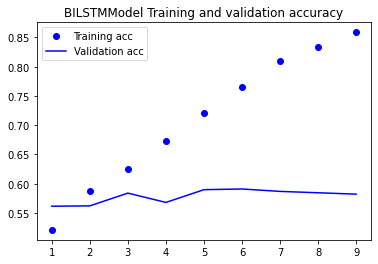

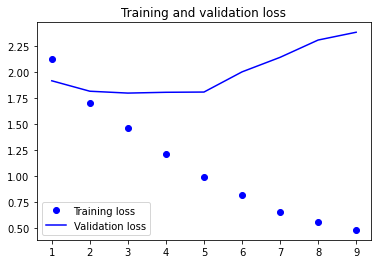

In [44]:
tuner =MyTuner(
    BILSTM_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40C"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

In [45]:
print("Accuracy of BILSTM for unaugmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of BILSTM for unagumented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of BILSTM for unaugmented data is :",np.array(history.history['loss']).mean())

Accuracy of BILSTM for unaugmented data is : 57.89301461643643
Training Accuracy of BILSTM for unagumented data is: 71.05444206131828
Mean loss of  Validation data of BILSTM for unaugmented data is : 1.9995683828989665
Mean loss of  Training data of BILSTM for unaugmented data is : 1.1122389833132427


Trial 5 Complete [00h 05m 03s]
val_accuracy: 0.5403653383255005

Best val_accuracy So Far: 0.5403653383255005
Total elapsed time: 00h 24m 11s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/40D\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
Score: 0.5403653383255005
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.4920447766780853
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
Score: 0.483205646276474
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.483205646276474
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
Score: 0.20329993963241577
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          300

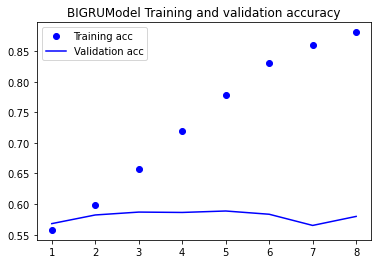

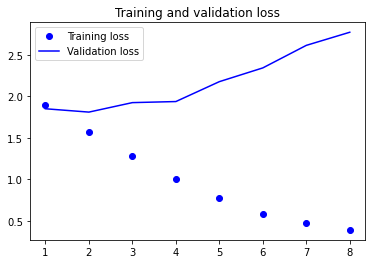

In [46]:
tuner =MyTuner(
    BIGRU_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40D"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

In [47]:
print("Accuracy of BIGRU for unaugmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of BIGRU for unagumented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of BIGRU for unaugmented data is :",np.array(history.history['loss']).mean())

Accuracy of BIGRU for unaugmented data is : 58.00677686929703
Training Accuracy of BIGRU for unagumented data is: 73.5259436070919
Mean loss of  Validation data of BIGRU for unaugmented data is : 2.180098280310631
Mean loss of  Training data of BIGRU for unaugmented data is : 0.9979034997522831


In [12]:
X_aug1 = (data_dl_aug1["Combined Description Cleaned"])
y_aug1= (data_dl_aug1['Assignment group'])

#categorical encoding y
y_aug1=pd.get_dummies(data_dl_aug2['Assignment group'])


X_aug2 = (data_dl_aug2["Combined Description Cleaned"])
y_aug2= (data_dl_aug2['Assignment group'])

#categorical encoding y
y_aug2=pd.get_dummies(data_dl_aug2['Assignment group'])
  

In [13]:
#tokenization
X_aug1,tokenizer = dfTokenizer(data_dl_aug1["Combined Description Cleaned"]) 
vocab_size_aug1=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug1)

X_aug2,tokenizer = dfTokenizer(data_dl_aug2["Combined Description Cleaned"]) 
vocab_size_aug2=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug2)

vocabulary size is:  3956
vocabulary size is:  4424


In [14]:
#padding
X_aug1=pad_sequences(X_aug1,padding='post')
X_aug2=pad_sequences(X_aug2,padding='post')
y_aug1=y_aug1[0:17586]

In [15]:
#split the data.Only augmented data is split using stratify
def split_stratify(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl

X_train_aug1,X_test_aug1,y_train_aug1,y_test_aug1=split_stratify(X_aug1,y_aug1)
X_train_aug2,X_test_aug2,y_train_aug2,y_test_aug2=split_stratify(X_aug2,y_aug2)


inp_len1=X_aug1.shape[1]
print(inp_len1)

191


In [16]:
#Simple LSTM model1
def LSTM_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(LSTM(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model



#Using GRU
def GRU_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(GRU(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model


 #Using bidirectional LSTM

def BILSTM_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(LSTM(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model


#Using bidirectional GRU
def BIGRU_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(GRU(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model




INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/40e\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 191, 512)          1665024   
_________________________________________________________________
dropout (Dropout)            (None, 191, 512)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 191, 512)          262656    
_________________________________________________________________
flatten (Flatten)            (None, 97792)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7236682   
Total params: 12

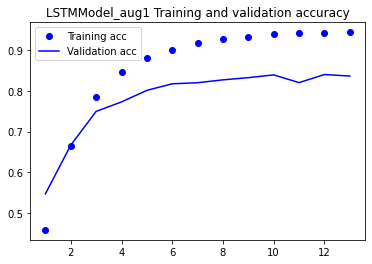

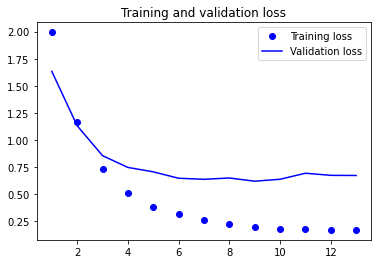

In [25]:
tuner =MyTuner(
    LSTM_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40e"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_LSTM,history)

In [26]:
print("Accuracy of LSTM for level1 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of LSTM for level1 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of LSTM for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of LSTM for level1 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of LSTM for level1 augmented data is : 78.26562386292679
Training Accuracy of LSTM for level1 augmented data is: 85.28848909414731
Mean loss of  Validation data of LSTM for level1 augmented data is : 0.7900317311286926
Mean loss of  training data of LSTM for level1 augmented data is : 0.49615159172278184


In [72]:
                                                                                                   
#x

In [73]:
tuner =MyTuner(
    GRU_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40Z"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)

Trial 5 Complete [00h 04m 41s]
val_accuracy: 0.36043205857276917

Best val_accuracy So Far: 0.36043205857276917
Total elapsed time: 00h 23m 50s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/40Z\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
Score: 0.36043205857276917
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.24616259336471558
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
Score: 0.2038089781999588
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
Score: 0.20181921124458313
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
Score: 0.08840250223875046
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)     

{'learning_rate': 0.001, 'batch_size': 256}
Epoch 1/25
55/55 [==============================] - 279s 5s/step - loss: 1.8264 - accuracy: 0.5026 - val_loss: 1.4363 - val_accuracy: 0.6040
Epoch 2/25
55/55 [==============================] - 275s 5s/step - loss: 0.9177 - accuracy: 0.7346 - val_loss: 0.8936 - val_accuracy: 0.7413
Epoch 3/25
55/55 [==============================] - 278s 5s/step - loss: 0.5350 - accuracy: 0.8409 - val_loss: 0.7149 - val_accuracy: 0.7879
Epoch 4/25
55/55 [==============================] - 239s 4s/step - loss: 0.3563 - accuracy: 0.8896 - val_loss: 0.5628 - val_accuracy: 0.8323
Epoch 5/25
55/55 [==============================] - 238s 4s/step - loss: 0.2679 - accuracy: 0.9193 - val_loss: 0.5564 - val_accuracy: 0.8394
Epoch 6/25
55/55 [==============================] - 238s 4s/step - loss: 0.2181 - accuracy: 0.9328 - val_loss: 0.5273 - val_accuracy: 0.8488
Epoch 7/25
55/55 [==============================] - 238s 4s/step - loss: 0.1803 - accuracy: 0.9418 - val_loss:

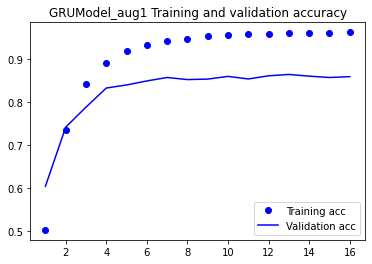

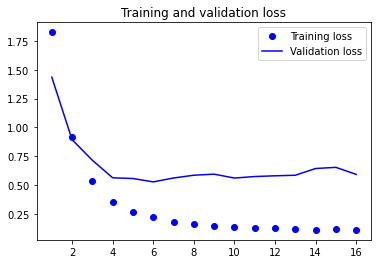

In [74]:
modelname="GRUModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_GRU,history)

In [75]:
print("Accuracy of GRU for level1 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of GRU for level1 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of GRU for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of GRU for level1 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of GRU for level1 augmented data is : 82.67481587827206
Training Accuracy of GRU for level1 augmented data is: 89.84930403530598
Mean loss of  Validation data of GRU for level1 augmented data is : 0.6637609228491783
Mean loss of  training data of GRU for level1 augmented data is : 0.3409577514976263


Trial 5 Complete [00h 12m 31s]
val_accuracy: 0.3320068120956421

Best val_accuracy So Far: 0.3320068120956421
Total elapsed time: 00h 56m 53s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/40F\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
Score: 0.3320068120956421
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.24673110246658325
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
Score: 0.19926095008850098
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
Score: 0.17026719450950623
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 512
Score: 0.17026719450950623
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)       

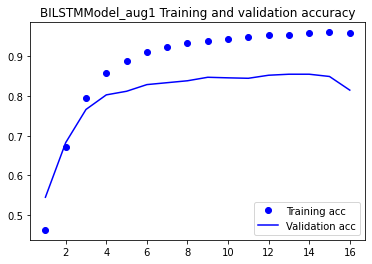

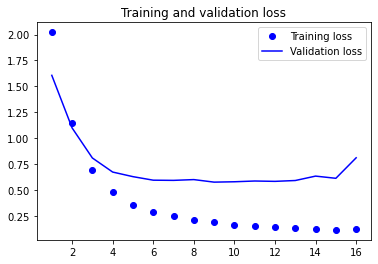

In [76]:
tuner =MyTuner(
    BILSTM_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40F"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

In [77]:
print("Accuracy of BILSTM for level1 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of BILSTM for level1 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BILSTM for level1 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of BILSTM for level1 augmented data is : 80.47185875475407
Training Accuracy of BILSTM for level1 augmented data is: 87.90251016616821
Mean loss of  Validation data of BILSTM for level1 augmented data is : 0.7225862517952919
Mean loss of  training data of BILSTM for level1 augmented data is : 0.40896331472322345


Trial 5 Complete [00h 12m 44s]
val_accuracy: 0.35218873620033264

Best val_accuracy So Far: 0.35218873620033264
Total elapsed time: 00h 57m 30s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/40G\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
Score: 0.35218873620033264
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.2441728264093399
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
Score: 0.1986924409866333
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
Score: 0.19755542278289795
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 512
Score: 0.17026719450950623
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)      

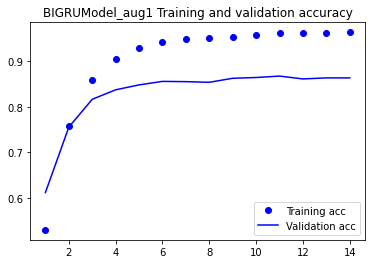

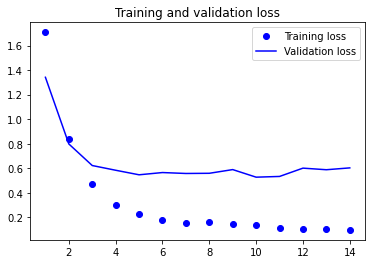

In [78]:
tuner =MyTuner(
    BIGRU_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40G"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

In [79]:
print("Accuracy of BIGRU for level1 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of BIGRU for level1 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BIGRU for level1 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of BIGRU for level1 augmented data is : 82.98546160970416
Training Accuracy of BIGRU for level1 augmented data is: 89.88738400595528
Mean loss of  Validation data of BIGRU for level1 augmented data is : 0.6437162458896637
Mean loss of  training data of BIGRU for level1 augmented data is : 0.3382162499640669


Trial 10 Complete [00h 13m 14s]
val_accuracy: 0.15004003047943115

Best val_accuracy So Far: 0.5482786297798157
Total elapsed time: 01h 45m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/40I\untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
Score: 0.5482786297798157
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.3556445240974426
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.3391513228416443
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
Score: 0.3159327507019043
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
Score: 0.24355484545230865
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)          

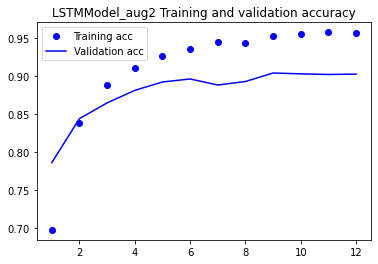

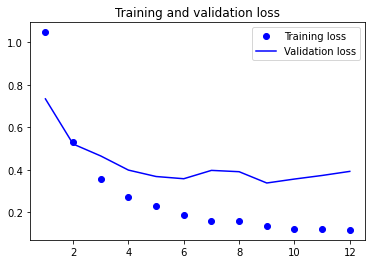

In [85]:
#x

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/4OJ\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)          3000000   
_________________________________________________________________
gru (GRU)                    (None, 191, 512)          1250304   
_________________________________________________________________
dropout (Dropout)            (None, 191, 512)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 191, 512)          262656    
_________________________________________________________________
flatten (Flatten)            (None, 97792)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7236682   
Total params: 11

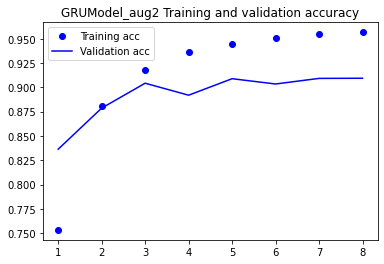

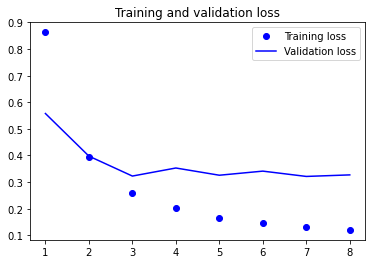

In [86]:
tuner =MyTuner(
    GRU_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/4OJ"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)


modelname="GRUModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_GRU,history)

In [87]:
print("Accuracy of GRU for level2 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of GRU for level2 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of GRU for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of GRU for level2 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of GRU for level2 augmented data is : 89.27541971206665
Training Accuracy of GRU for level2 augmented data is: 91.20605736970901
Mean loss of  Validation data of GRU for level2 augmented data is : 0.36826013028621674
Mean loss of  training data of GRU for level2 augmented data is : 0.2850606543943286


INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/40K\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 191, 1024)         3330048   
_________________________________________________________________
dropout (Dropout)            (None, 191, 1024)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 191, 512)          524800    
_________________________________________________________________
flatten (Flatten)            (None, 97792)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7236682   
Total params: 14

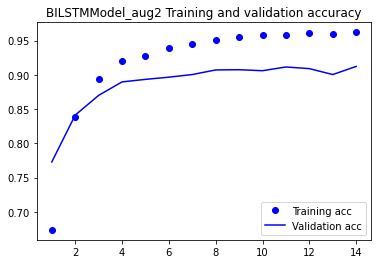

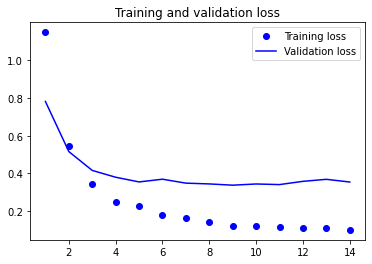

In [27]:
tuner =MyTuner(
    BILSTM_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40K"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

In [28]:
print("Accuracy of BILSTM for level2 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of BILSTM for level2 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BILSTM for level2 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of BILSTM for level2 augmented data is : 88.69724358831134
Training Accuracy of BILSTM for level2 augmented data is: 91.75122337681907
Mean loss of  Validation data of BILSTM for level2 augmented data is : 0.401363159929003
Mean loss of  training data of BILSTM for level2 augmented data is : 0.26301945373415947


In [20]:
#x

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/40L\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 191, 1024)         2500608   
_________________________________________________________________
dropout (Dropout)            (None, 191, 1024)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 191, 512)          524800    
_________________________________________________________________
flatten (Flatten)            (None, 97792)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7236682   
Total params: 13

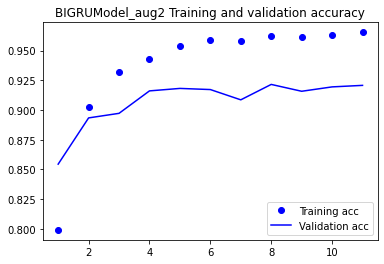

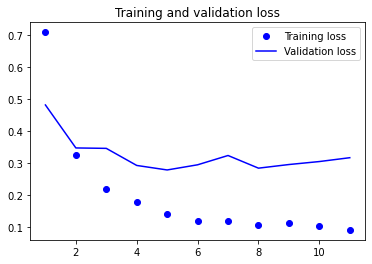

In [21]:





tuner =MyTuner(
    BIGRU_model1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40L"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

In [22]:
print("Accuracy of BIGRU for level2 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of BIGRU for level2 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BIGRU for level2 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of BIGRU for level2 augmented data is : 90.75041900981556
Training Accuracy of BIGRU for level2 augmented data is: 93.63279613581571
Mean loss of  Validation data of BIGRU for level2 augmented data is : 0.3235979296944358
Mean loss of  training data of BIGRU for level2 augmented data is : 0.20142006264491516


INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/40I\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 191, 300)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 191, 512)          1665024   
_________________________________________________________________
dropout (Dropout)            (None, 191, 512)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 191, 512)          262656    
_________________________________________________________________
flatten (Flatten)            (None, 97792)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7236682   
Total params: 12

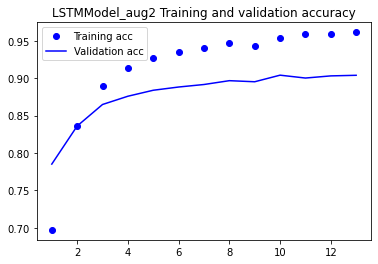

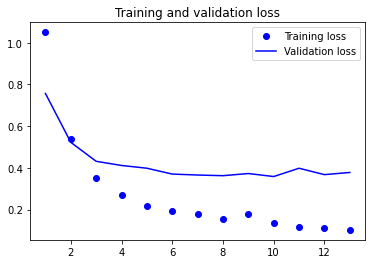

In [23]:
tuner =MyTuner(
    LSTM_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/40I"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
#epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_LSTM,history)

In [24]:
print("Accuracy of LSTM for level2 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
print("Training Accuracy of LSTM for level2 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of LSTM for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of LSTM for level2 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of LSTM for level2 augmented data is : 87.91525547321027
Training Accuracy of LSTM for level2 augmented data is: 91.25160162265485
Mean loss of  Validation data of LSTM for level2 augmented data is : 0.4224692491384653
Mean loss of  training data of LSTM for level2 augmented data is : 0.2763491960672232
